**Project Idea: Airbnb Listing Price Analysis and Prediction for Rio de Janeiro**

**Project Overview:**
<br>The goal of this project is to analyze Airbnb listing data for Rio de Janeiro to uncover insights about the factors that influence listing prices and build a predictive model to estimate the price of new listings. This can provide valuable information for both hosts looking to optimize their pricing strategy and travelers searching for accommodations within their budget.

**Steps Taken:**

1. **Data Exploration and Cleaning:**
    <br>Load and examine the dataset to understand its structure and features.
    Handle missing data and outliers appropriately.
    Explore the distribution of key variables like price, neighborhoods, property type, amenities, etc.

2. **Exploratory Data Analysis (EDA):**
    <br>Conduct in-depth analyses to uncover patterns and trends in the data.
    Visualize price distributions and correlations between variables.
    Identify high-demand areas and popular property types.
    
3. **Feature Engineering: (to be done...)**
    <br>Create new features that might impact pricing, such as distance to popular attractions, neighborhood characteristics, and availability trends.
    Encode categorical variables like property type, room type, and amenities using techniques like one-hot encoding.

4. **Price Prediction Model: (to be done...)**
    <br>Split the dataset into training and testing sets.
    Select appropriate machine learning algorithms for regression (e.g., Linear Regression, Random Forest, Gradient Boosting, etc.).
    Train the chosen models on the training data and evaluate their performance using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

5. **Interpretation and Insights: (to be done...)**
    <br>Interpret the model's coefficients or feature importances to understand which factors have the most significant impact on listing prices.
    Provide insights into the optimal pricing strategy for hosts, such as adjusting prices based on amenities or neighborhood.
    
**Important Info:**

- The dataset was provided by [Inside Airbnb](http://insideairbnb.com/rio-de-janeiro/) and downloaded from [this page](http://insideairbnb.com/get-the-data).
- The data dictionary for this dataset can be [found here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/).

### Main Insights from the Analysis:

1. **Most Popular Accommodation Types**: Entire homes/apartments are the most commonly rented types of accommodations on Airbnb in Rio de Janeiro, making up around 78% of listings. Private rooms come second at 20%, followed by shared rooms at 2%. Hotel rooms represent less than 0.2% of the listings.

2. **Room Type Distribution by Neighborhood**: Most neighborhoods have more entire home/apartment listings than private rooms, except for Santa Teresa, which has a substantial number of private rooms. Entire rental units make up the majority of listings (60%), followed by private rooms in rental units (12%).

3. **Geographic Distribution**: Listings are highly concentrated near famous beaches like Copacabana, Ipanema, Barra da Tijuca, and Leblon. There are also listings in urban and central areas like Jacarepaguá, Santa Teresa, Centro, and Tijuca.

4. **Price Range**: The majority of listings fall in the price range of \\$150 to \\$350 per night, with an average of \\$469 and a median of \\$300. More upscale neighborhoods tend to have higher prices, while areas with slums and higher violence levels have lower prices.

5. **Price Variation by Neighborhood**: Different neighborhoods have varying price ranges. Centro, Botafogo, Santa Teresa, and Flamengo usually have prices between \\$170/night and \\$250/night. More expensive neighborhoods like Ipanema, Recreio dos Bandeirantes, Leblon, and Barra da Tijuca have prices between \\$370/night and \\$520/night.

6. **Correlation with Number of Bedrooms and Beds**: There is a correlation between the number of bedrooms/beds and price, but after a certain point (7 bedrooms or 15 beds), the price tends to plateau, although there are very few listings with more than 7 bedrooms.

7. **Amenities and Price**: The number of amenities (up to around 50) doesn't significantly affect the price. However, when the total number of amenities exceeds 60, the price tends to increase. Further analysis can explore which amenities are more correlated with prices.

In [1]:
# Importing main libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# plt.style.use('bmh')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Setting file paths
# path_reviews = '../data/reviews.csv.gz'
# path_calendar = '../data/calendar.csv.gz'
# path_listing_summary = '../data/listings.csv'
path_listing_detailed = '../data/listings.csv.gz'
# path_neighbourhoods = '../data/neighbourhoods.csv'

# Reading main detailed listing dataset
df = pd.read_csv(path_listing_detailed)

### General info

In [2]:
print(f'Total number of listings: {df.shape[0]}')
print(f'Total number of features: {df.shape[1]}')
print(f'Total number of hosts: {df["host_id"].nunique()}')
print(f'Total number of neighbourhoods listed: {df["neighbourhood_cleansed"].nunique()}')

Total number of listings: 31401
Total number of features: 75
Total number of hosts: 19472
Total number of neighbourhoods listed: 153


### Dealing with missing values

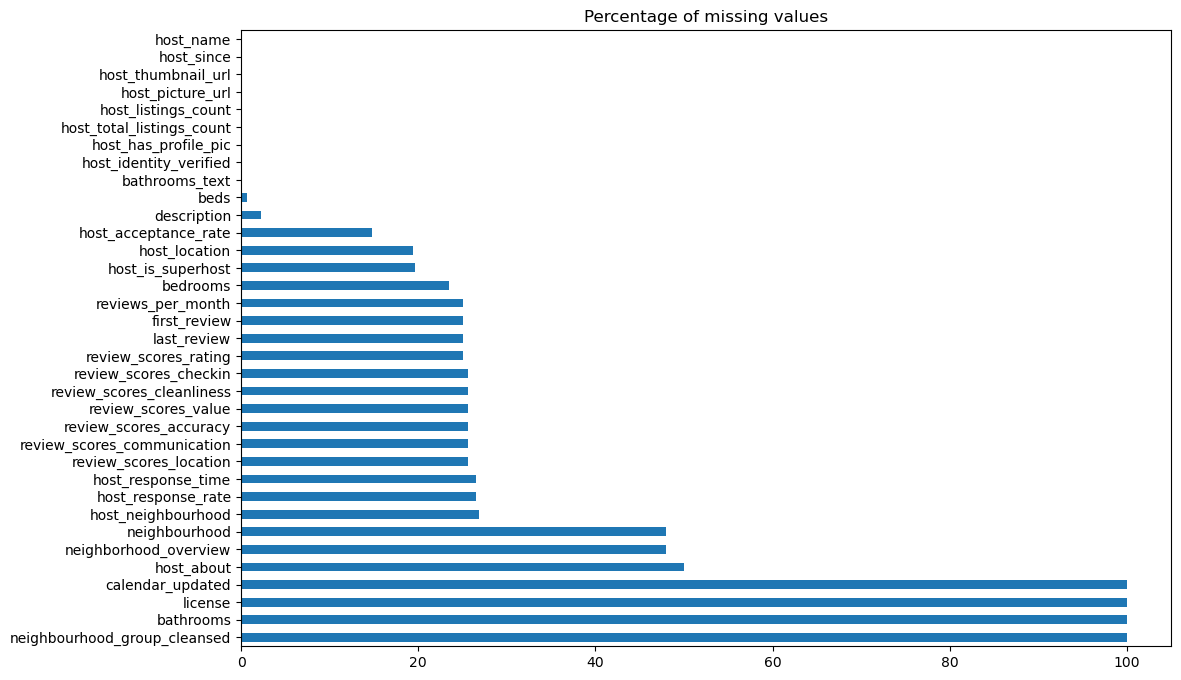

In [3]:
missing_values = df.isna().mean()*100

missing_values = missing_values[missing_values != 0]

plt.figure(figsize=(12, 8))
missing_values.sort_values(ascending=False).plot(kind='barh')
plt.title('Percentage of missing values');

- Since there are no values in this dataset for `bathrooms`, `license`, `calendar_updated` and `neighbourhood_group_cleansed`, we can simply drop these columns. Unnecessary columns, such as `listing_url`, `scrape_id`, `last_scraped` and `source` will be dropped as well.

- About 50% of the data is missing for the `host_about` column. Also there are other columns with much less data than expected, so we will be dealing with each one of those in specific ways.

In [4]:
# Dropping unnecessary or full null columns
df = df.drop(columns=['neighbourhood', 'neighbourhood_group_cleansed','bathrooms','calendar_updated', 'license','listing_url',
                      'scrape_id','last_scraped','source'])

In [5]:
# Correcting data type and data cleaning
df['id'] = df['id'].astype(str)
df['host_id'] = df['host_id'].astype(str)
df['host_total_listings_count'] = df['host_total_listings_count'].astype('Int64')
df['host_listings_count'] = df['host_listings_count'].astype('Int64')
df['beds'] = df['beds'].astype('Int64')
df['bedrooms'] = df['bedrooms'].astype('Int64')

df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '').astype(float)

df = df[df['accommodates'] != 0]
df = df.dropna(subset=['bedrooms', 'beds'])

C:\Users\rodol\AppData\Local\Temp\ipykernel_7228\8663994.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '')


In [6]:
# # Calculate average bedrooms per accommodate for rows with non-missing bedroom values
# average_bedrooms_per_accommodate = df.dropna(subset=['bedrooms']).groupby('accommodates')['bedrooms'].mean().round(0)

# # Function to fill missing bedroom values based on average
# def fill_missing_bedrooms(row):
#     if pd.isna(row['bedrooms']):
#         if row['accommodates'] in average_bedrooms_per_accommodate.values:
#             return average_bedrooms_per_accommodate[row['accommodates']]
#     return row['bedrooms']

# # Apply the function to fill missing bedroom values
# df['bedrooms'] = df.apply(fill_missing_bedrooms, axis=1)

In [7]:
# # Calculate average beds per accommodate for rows with non-missing bedroom values
# average_beds_per_accommodate = df.dropna(subset=['beds']).groupby('accommodates')['beds'].mean().round(0)

# # Function to fill missing bedroom values based on average
# def fill_missing_beds(row):
#     if pd.isna(row['beds']):
#         if row['accommodates'] in average_beds_per_accommodate.values:
#             return average_beds_per_accommodate[row['accommodates']]
#     return row['beds']

# # Apply the function to fill missing bedroom values
# df['beds'] = df.apply(fill_missing_beds, axis=1)

In [8]:
# Counting how many amenities each accommodation has and creating a new column with the count
df['total_amenities'] = df['amenities'].str.strip('[]').str.split(',', expand=True).apply(lambda x: x.count(), axis=1)

# Setting 'total_amenities' to 0 if 'amenities' == '[]'
df.loc[df['amenities'].apply(lambda x: x == '[]'), 'total_amenities'] = 0

In [9]:
# Checking the percentage of missing values in dataframe
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

missing_value_df

,percent_missing
id,0.00
name,0.00
description,2.00
neighborhood_overview,48.06
picture_url,0.00
...,...
calculated_host_listings_count_entire_homes,0.00
calculated_host_listings_count_private_rooms,0.00
calculated_host_listings_count_shared_rooms,0.00
reviews_per_month,24.60


- Most of our missing values are from columns with host information, such as `host_response_time` and `host_response rate` or with review information. These features can be used in our analysis, but since we'll be focusing on features such as listing location, price, property type and amenities, we won't be filling or dropping these missing values for now.

### Outliers

There are three columns in this dataset that have outliers: `price`, `minimum_nights` and `maximum_nights`.

- In the boxen plots below, the `price` feature clearly shows a high number of outliers in the upper area. There's also a lot of outliers in the `minimum_nights` column and a few in `maximum_nights`.

- We'll identify these high values using quantiles. For the `price` column, anything above the 97th percentile will be dropped. This won't affect much of our analysis, since these values represent only 4% of our dataset. If we wanted to keep them for future deeper analysis or creating more complex machine learning models, we could use other features in the dataset to calculate a reasonable price for each listing, or simply capping the outliers at a certain percentile (97th, in this case), effectively replacing them with less extreme values.

- Capping outliers is exactly what we'll be doing for both the `minimum_nights` and `maximum_nights` columns. We'll be replacing them with their 0.9 quantiles.

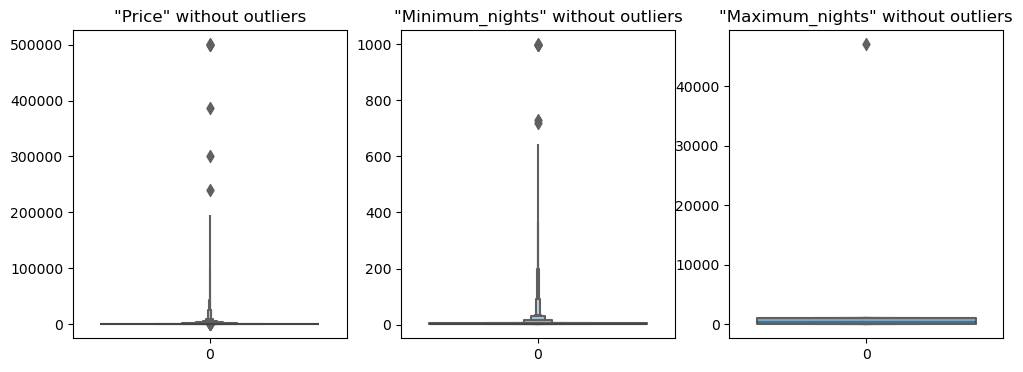

In [10]:
# Plotting "price", "minimum_nights" and "maximum_nights" columns with outliers
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.boxenplot(df['price'], ax=axes[0], palette='Blues')
axes[0].set_title('"Price" without outliers')

sns.boxenplot(df['minimum_nights'], ax=axes[1], palette='Blues')
axes[1].set_title('"Minimum_nights" without outliers')

sns.boxenplot(df['maximum_nights'], ax=axes[2], palette='Blues')
axes[2].set_title('"Maximum_nights" without outliers')

plt.show()

In [11]:
# Dropping 'price' values above the 97th percentile
df = df[df['price'] < df['price'].quantile(0.97)]

# Clipping outliers in 'minimum_nights' and 'maximum_nights'
df['minimum_nights'] = df['minimum_nights'].clip(upper=df['minimum_nights'].quantile(0.90))

df['maximum_nights'] = df['maximum_nights'].clip(upper=df['maximum_nights'].quantile(0.90))

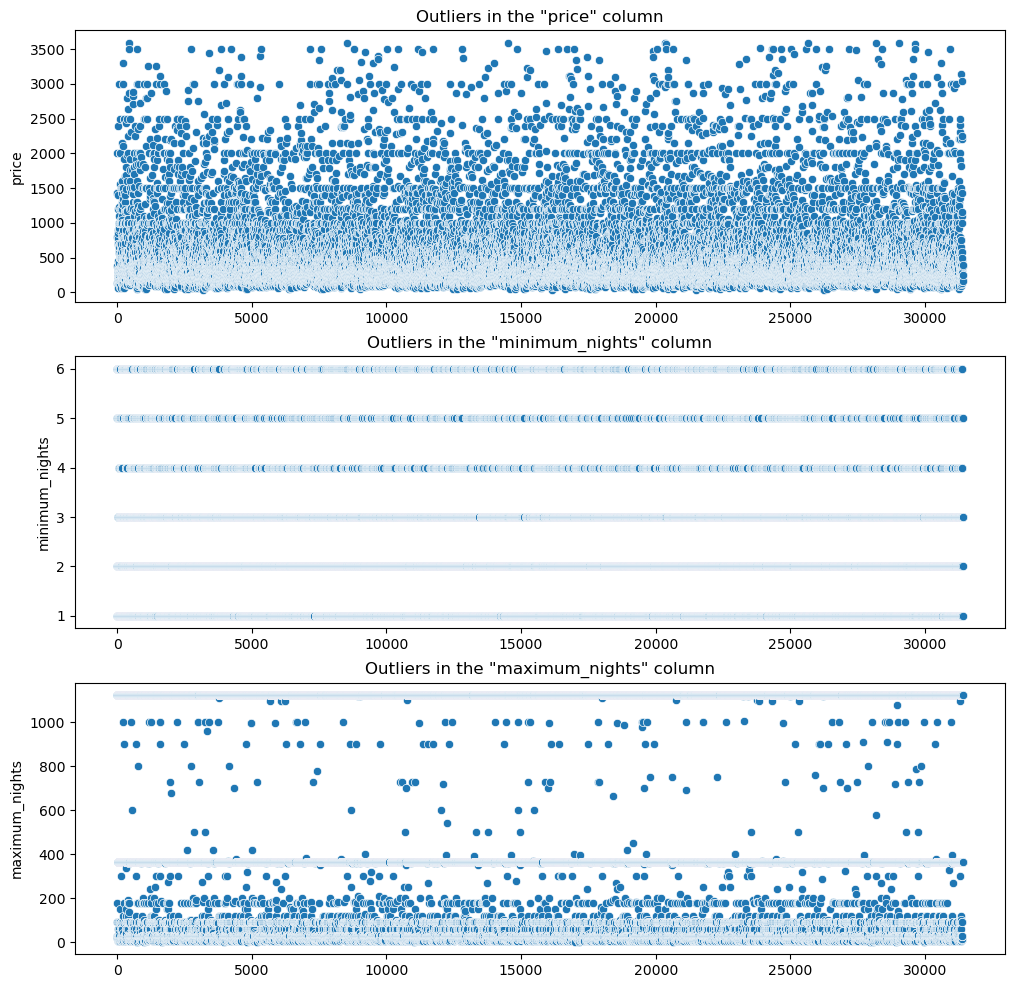

In [12]:
# Plotting "price", "minimum_nights" and "maximum_nights" columns with outliers removed or treated
fig, axes = plt.subplots(3, 1, figsize=(12,12))

sns.scatterplot(df['price'], ax=axes[0])
axes[0].set_title('Outliers in the "price" column')

sns.scatterplot(df['minimum_nights'], ax=axes[1])
axes[1].set_title('Outliers in the "minimum_nights" column')

sns.scatterplot(df['maximum_nights'], ax=axes[2])
axes[2].set_title('Outliers in the "maximum_nights" column')

plt.show()

### Exploratory Data Analysis

### Room type

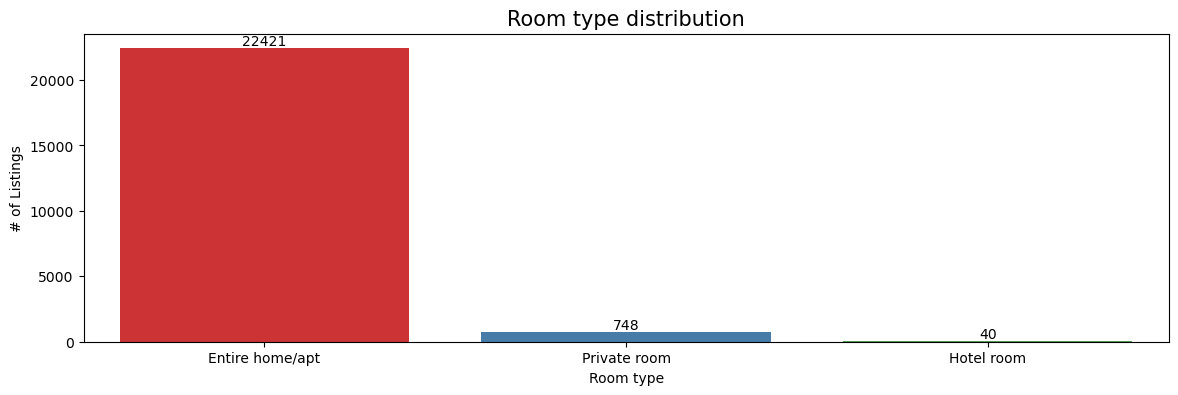

In [13]:
# Plotting room type distribution
plt.figure(figsize=(14, 4))

ax = sns.countplot(data=df, x='room_type', order=df['room_type'].value_counts().index, palette='Set1')

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

plt.xlabel('Room type')
plt.ylabel('# of Listings')
plt.title('Room type distribution', fontsize=15)
plt.show()

In [14]:
# Filtering the main dataframe with only listings for the 10 most common neighborhoods
mostcommon_neighbs = df[df['neighbourhood_cleansed'].isin(df['neighbourhood_cleansed'].value_counts().iloc[:10].index)]

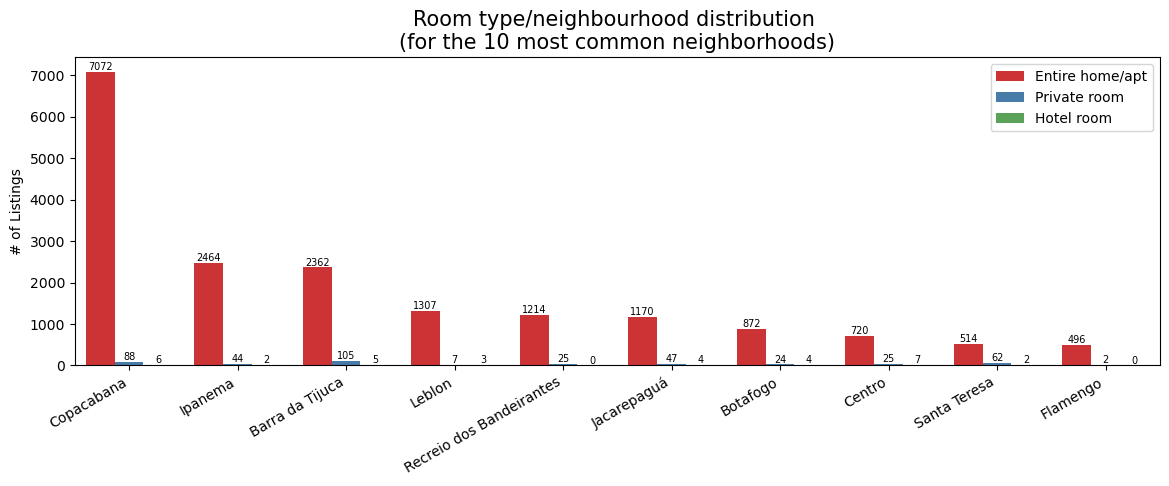

In [15]:
# Plotting room type distribution by neighborhood for the 10 most common neighborhoods
plt.figure(figsize=(14, 4))

ax = sns.countplot(data=mostcommon_neighbs, x='neighbourhood_cleansed', hue='room_type', 
                   order=mostcommon_neighbs['neighbourhood_cleansed'].value_counts().index, palette='Set1')

for i in ax.containers:
    ax.bar_label(i, fontsize=7)

plt.xlabel('')
plt.ylabel('# of Listings')
plt.xticks(rotation=30, ha='right')
plt.title('Room type/neighbourhood distribution \n(for the 10 most common neighborhoods)', fontsize=15)
plt.legend(loc='upper right', facecolor='white')
plt.show()

**Entire home/apartments** are always the most rented places in AirBnB (this probably applies to most cities in the world). It's not any different in Rio de Janeiro. Around 78% of the accommodations are entire places.

**Private rooms** come in second with 6296 listings, or 20%, followed by **Shared rooms** with 515 listings (2%).

**Hotel rooms** are not AirBnB's most predominant product, since hotels usually have different platforms to book their rooms, such as **Trivago** and **Expedia**. In this dataset, less than 0.2% (45) of the listings are hotel rooms.

Looking at the room type by neighborhood distribution, we can see that **most districts have way more entire home/apartments for rent than private rooms**, except for Santa Teresa, which have almost as many private rooms as entire places.

### Property type

In [16]:
# Filtering property types that appear at least 10 times
property_type_abv_ten = df[df['property_type'].map(df['property_type'].value_counts()) > 10]

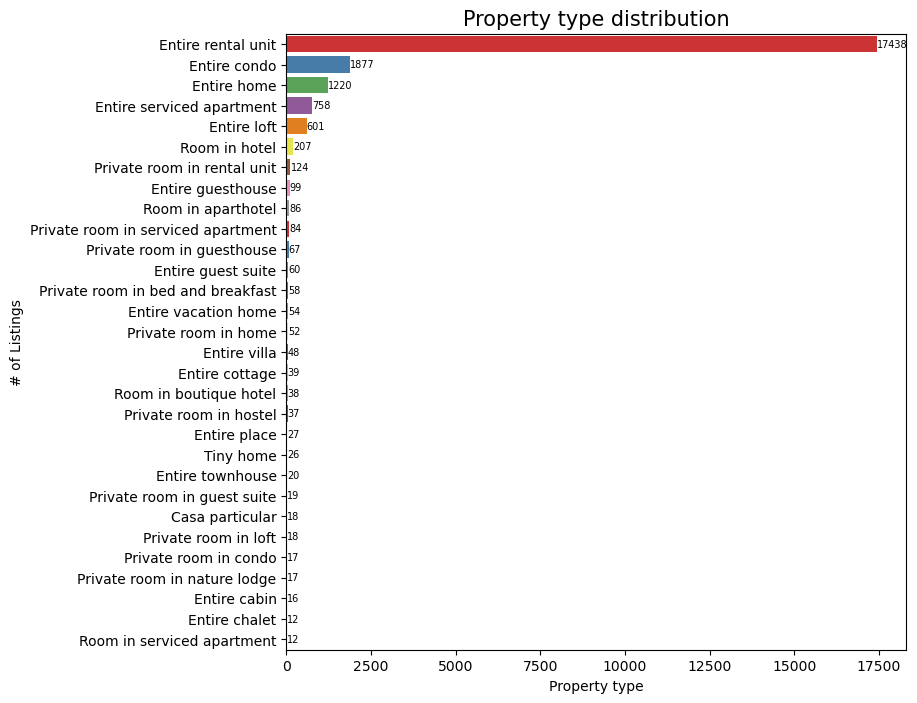

In [17]:
# Plotting property type distribution
plt.figure(figsize=(8, 8))

ax = sns.countplot(data=property_type_abv_ten, y='property_type', 
                   order=property_type_abv_ten['property_type'].value_counts().index, palette='Set1')

for i in ax.containers:
    ax.bar_label(i, fontsize=7)

plt.xlabel('Property type')
plt.ylabel('# of Listings')
plt.title('Property type distribution', fontsize=15)
plt.show()

Following the trend from our previous insight, most of the listings are **Entire rental units** (60%) followed by **Private rooms in rental units** (12%). There's also almost 2000 (6%) **Entire condos** and 1400 (5%) **Entire homes**.

### Listings distribution by neighbourhood 

In [18]:
# Creating a map showing the distribution of available accommodations for the city of Rio de Janeiro
dist_map_rj = folium.Map(location = [-22.908333, -43.456388], zoom_start=11)

HeatMap(df[['latitude','longitude']], radius=8, gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(dist_map_rj)

display(dist_map_rj)

With this interactive heatmap we can see the **neighborhoods with the highest number of accommodations for rent**.

There's definetely a **high concentration** of places near the most famous beaches of Rio, such as **Copacabana, Ipanema, Barra da Tijuca and Leblon**.

But we also see a lot of listings near **urban and central regions** such as **Jacarepaguá, Santa Teresa, Centro and Tijuca**.

### Price distribution

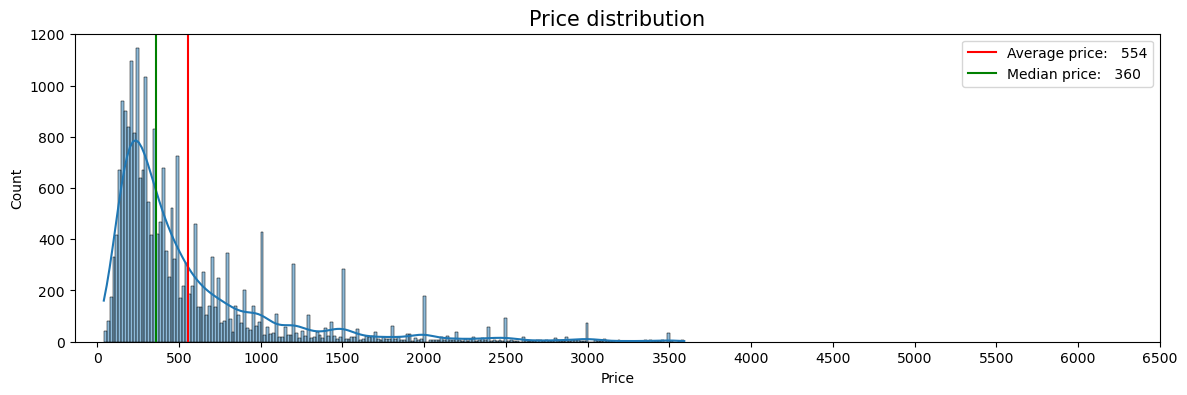

In [19]:
# Plotting price distribution for the entire dataset
plt.figure(figsize=(14,4))

sns.histplot(data=df, x='price', color='tab:blue', kde=True, bins=200)

plt.axvline(df['price'].mean(), color='r', label='Average price: {:5.0f}'.format(np.mean(df['price'])))
plt.axvline(df['price'].median(), color='g', label='Median price: {:5.0f}'.format(np.median(df['price'])))
plt.xlabel('Price')
plt.xticks(list(range(0, 7000, 500)))
plt.title('Price distribution', fontsize=15)
plt.legend()
plt.show();

According to plot above, price distribution for the entire dataset has a **higher concentration between \\$150 and \\$350/night**, an **average of $469** and a **median of \\$300**.

In [20]:
# Creating a dataframe with the total number of listings, total number of reviews, average price and reviews by listings ratio
# (for each neighborhood)
total_listings = df['neighbourhood_cleansed'].value_counts()

total_number_reviews = df.groupby('neighbourhood_cleansed')['number_of_reviews'].sum()

avg_price_neighb = df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

avg_review_neighb = df.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().sort_values(ascending=False)

neighb_data = pd.concat([total_listings, total_number_reviews, 
                         avg_price_neighb, avg_review_neighb], axis=1).sort_values(by='neighbourhood_cleansed',
                                                                                   ascending=False)

neighb_data = neighb_data.reset_index().rename(columns={'neighbourhood_cleansed': 'Total of listings',
                                                        'price': 'Average price',
                                                        'number_of_reviews': 'Total number of reviews',
                                                        'index': 'Neighborhood',
                                                        'review_scores_rating': 'Average review score'})

neighb_data['Reviews by listings ratio']=neighb_data['Total number of reviews']/neighb_data['Total of listings']

neighb_data.head()

,Neighborhood,Total of listings,Total number of reviews,Average price,Average review score,Reviews by listings ratio
0,Copacabana,7166,182334,466.45,4.74,25.44
1,Ipanema,2510,71974,686.13,4.77,28.67
2,Barra da Tijuca,2472,44993,690.70,4.74,18.20
3,Leblon,1317,31399,752.00,4.77,23.84
4,Recreio dos Bandeirantes,1239,16655,637.05,4.72,13.44


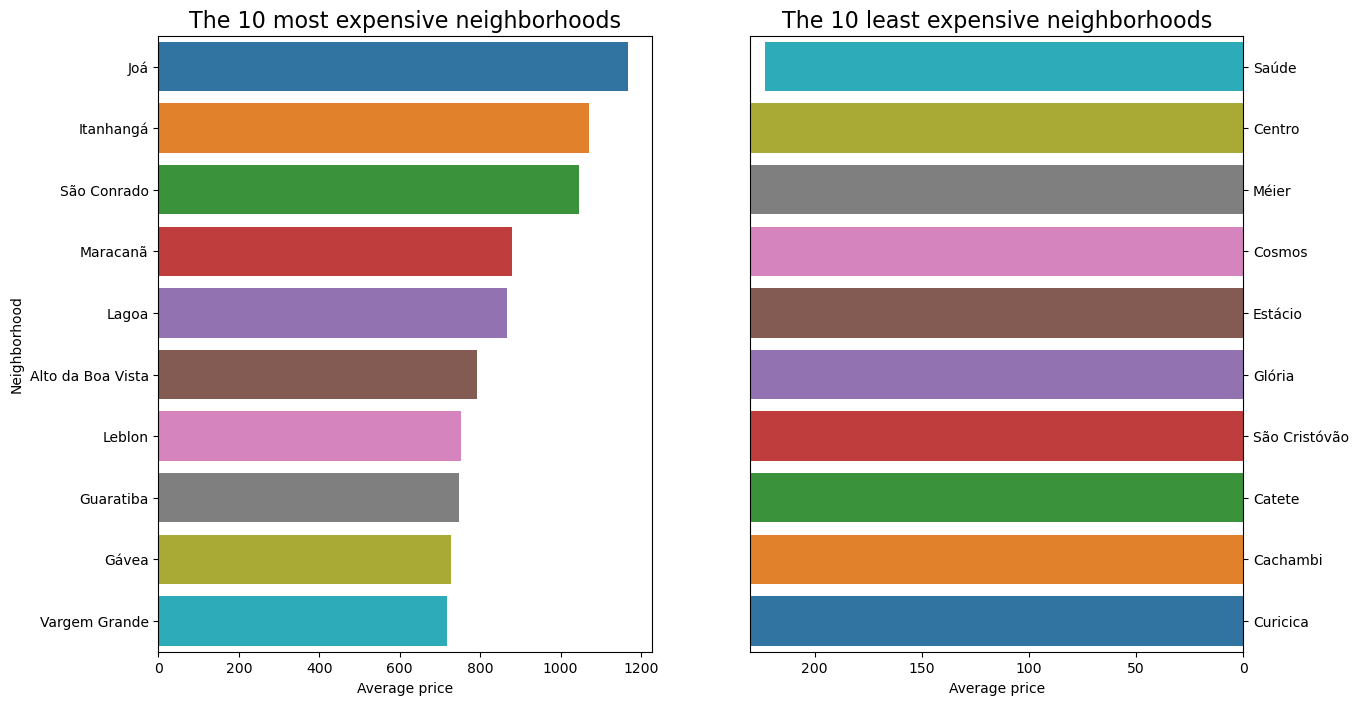

In [21]:
# Plotting the 10 most and 10 least expensive neighborhoods (for neighborhoods with at least 10 listings)
fig, axes = plt.subplots(1, 2, figsize=(14,8))

sns.barplot(data=neighb_data[neighb_data['Total of listings'] > 10]\
            .sort_values(by='Average price',ascending=False).iloc[:10], palette='tab10',
            x='Average price', y='Neighborhood', ax=axes[0])

axes[0].set_title('The 10 most expensive neighborhoods', fontsize=16)

sns.barplot(data=neighb_data[neighb_data['Total of listings'] > 10]\
            .sort_values(by='Average price',ascending=True).iloc[:10], palette='tab10_r',
            x='Average price', y='Neighborhood', ax=axes[1])

axes[1].set_title('The 10 least expensive neighborhoods', fontsize=16)
axes[1].set_xlim(230, 0)
axes[1].set_ylabel('')
axes[1].yaxis.tick_right()

As expected, upscale neighborhoods such as **Joá** and **São Conrado** offer more expensive listings, while districts with slums and higher levels of violence have much lower prices.

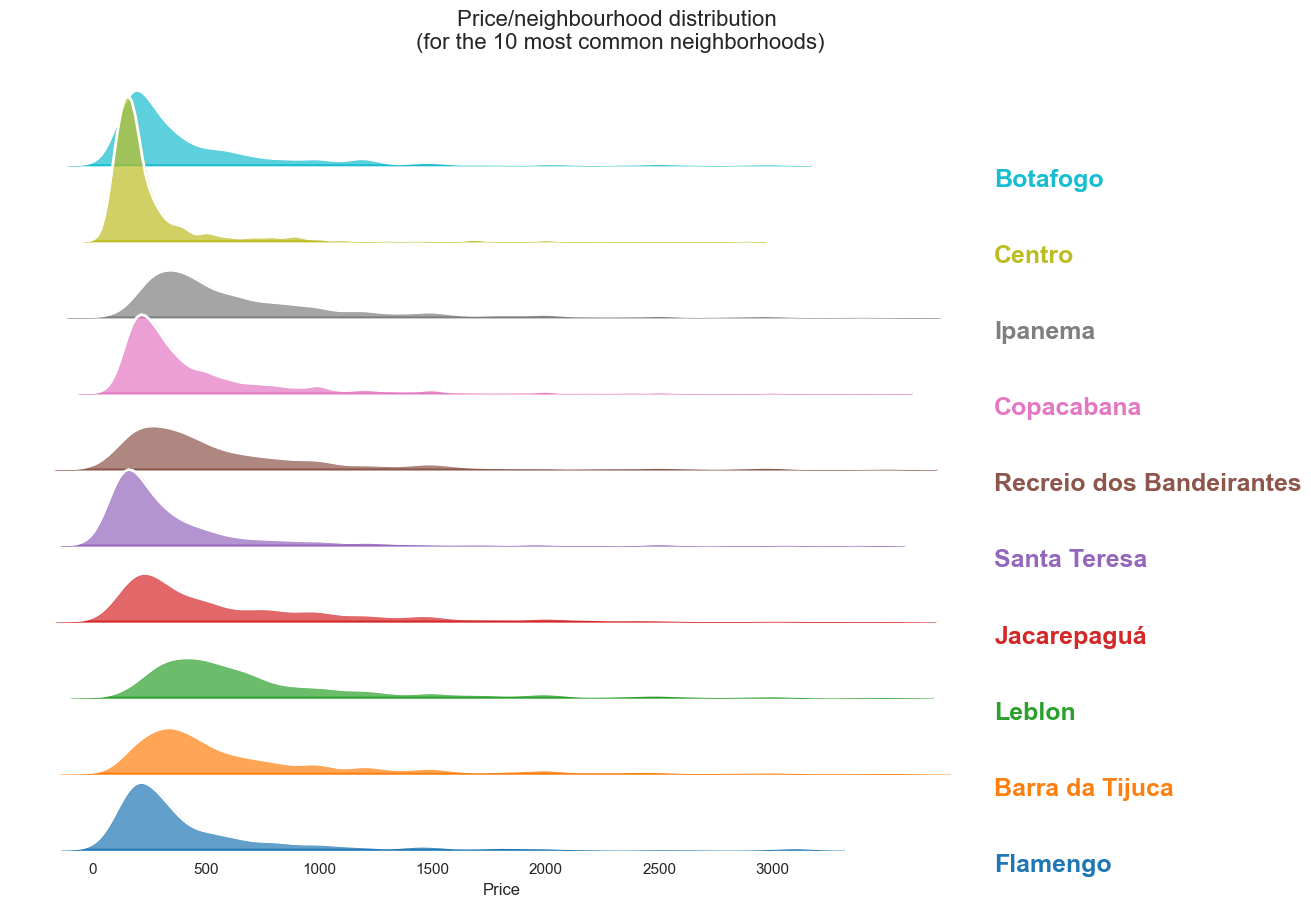

In [22]:
# Plotting a ridge plot with the price distribution for the 10 most common neighborhoods
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(mostcommon_neighbs, row="neighbourhood_cleansed", hue="neighbourhood_cleansed",
                  palette='tab10_r', aspect=8, height=1.75) 

g.map(sns.kdeplot, 'price', bw_adjust=.5, clip_on=False, fill=True, alpha=0.7, linewidth=1.5)
g.map(sns.kdeplot, 'price', clip_on=False, color="w", lw=2, bw_adjust=.5)

def label(x, color, label):
    ax = plt.gca()
    ax.text(1, -.1, label, fontweight="bold", color=color, ha="left", va="center", fontsize=18, transform=ax.transAxes)

g.map(label, "price")

g.fig.subplots_adjust(hspace=-.5)

g.set_titles("")

g.set(xticks=list(range(0, 3001, 500)))
g.set(yticks=[])
g.set(xlabel='Price')
g.set(ylabel='')
g.despine(bottom=True, left=True)
plt.subplots_adjust(bottom=.5)
g.fig.suptitle('Price/neighbourhood distribution \n(for the 10 most common neighborhoods)', fontsize=16)
plt.show()

The charts above show price variation for the ten most common neighborhoods in our dataset. **Centro, Botafogo, Santa Teresa and Flamengo** keep their prices usually at around between **\$170/night** and **\$250/night**. More expensive neighborhoods, such as **Ipanema, Recreio dos Bandeirantes, Leblon and Barra da Tijuca** have their prices better distributed, but with a higher density between **\$370/night** and **\$520/night**. 

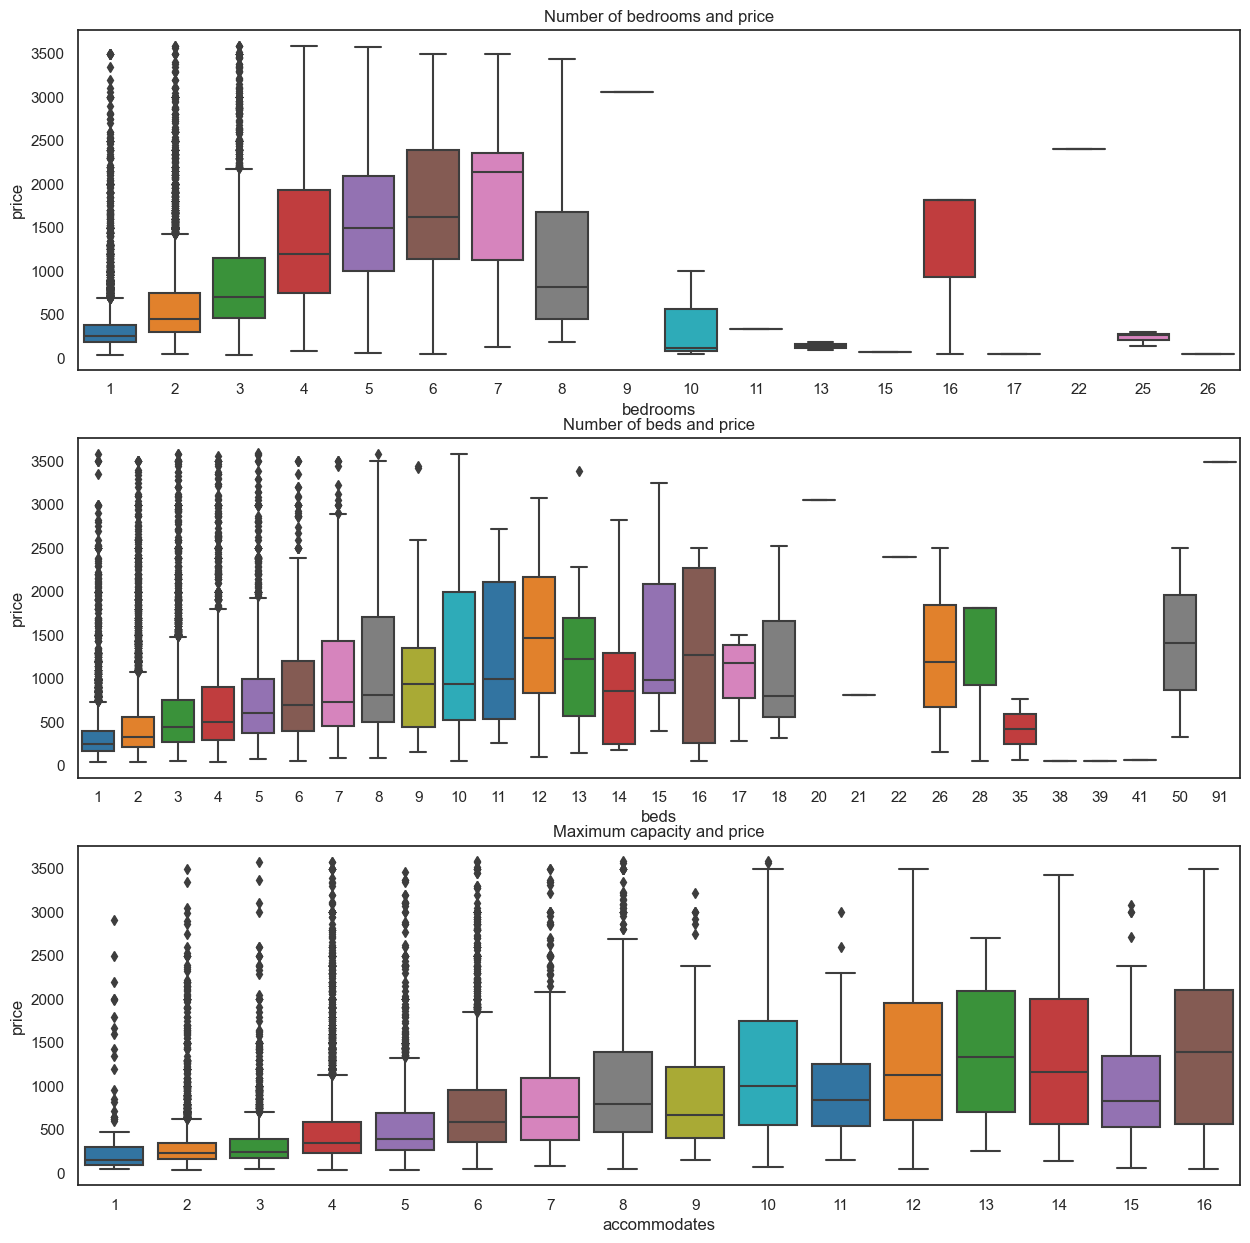

In [23]:
# Plotting the correlation between number of bedrooms/beds and price
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.boxplot(data=df, x='bedrooms', y='price', palette='tab10', ax=axes[0])

axes[0].set_title('Number of bedrooms and price', fontsize=12)

sns.boxplot(data=df, x='beds', y='price', palette='tab10', ax=axes[1])

axes[1].set_title('Number of beds and price', fontsize=12)

sns.boxplot(data=df, x='accommodates', y='price', palette='tab10', ax=axes[2])

axes[2].set_title('Maximum capacity and price', fontsize=12);

- Although predictable, there's a **high correlation** between number of bedrooms and price, but after **7 bedrooms** price tends to drop. This information may not be relevant, because there's a very small number of listings (21) with more than 7 bedrooms. 

- The same insight applies for number of beds and total capacity. As the number of beds and maximum number of accommodates increase, price also increases, but after **15 beds** it tends to stagnate and act randomly.

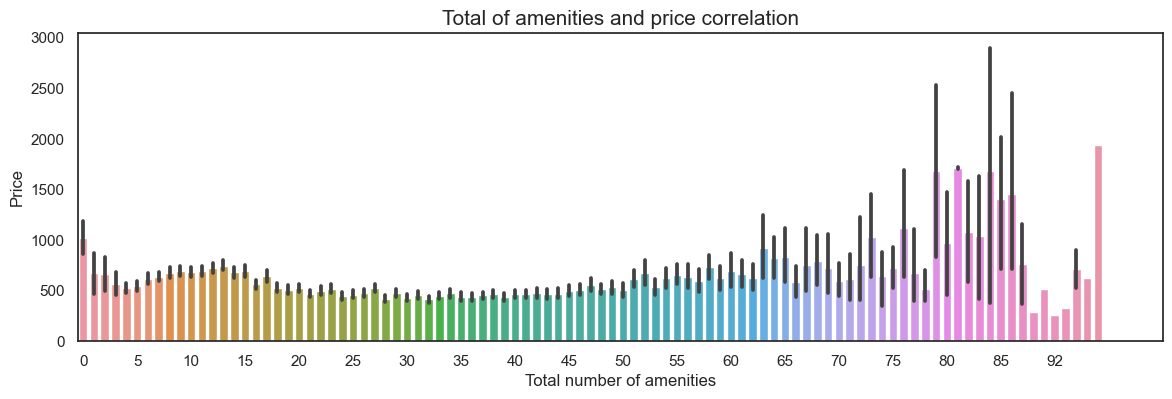

In [24]:
plt.figure(figsize=(14,4))

sns.barplot(data=df, x='total_amenities', y='price')

plt.xlabel('Total number of amenities')
plt.ylabel('Price')
plt.xticks(list(range(0, 101, 5)))
plt.title('Total of amenities and price correlation', fontsize=15)
plt.show();

- According the bar plot above, the range **between 0 and around 50 amenities don't affect much the price**. As the total of amenities **exceeds 60, the price tends to increase** (this might not be relevant, since listings with more than 60 amenities represent less than 2% of the data).

- Further analysis can be done to identify which amenities are better perceived by the customer and their correlation with prices.